In [3]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from sklearn.impute import SimpleImputer
from datetime import datetime
import os
import json
from dotenv import load_dotenv
load_dotenv()



True

In [ ]:
base_url = os.getenv("BASE_URL")
api_key = os.getenv("API_KEY")
dataset = "task_generation_h"
date_from = "2022-10-01"
date_to = "2022-12-31"

headers = { "API-Key": api_key}

params = {
    "dataset": dataset,
    "from": date_from,
    "to": date_to
}




In [5]:
os.makedirs('./data', exist_ok=True)
raw_data_file = './data/raw_energy_data.json'

In [6]:
try:
    if os.path.exists(raw_data_file):
        print(f"Loading data from {raw_data_file}...")
        with open(raw_data_file, 'r') as f:
            data = json.load(f)
    else:
        raise FileNotFoundError

except (FileNotFoundError):
    print("Local file missing or invalid. Fetching from API...")
    try:
        response = requests.get(base_url, headers=headers, params=params)
        response.raise_for_status()
        data = response.json()

        # Save raw API response
        with open(raw_data_file, 'w') as f:
            json.dump(data, f, indent=2)
        print(f"Raw API data saved to {raw_data_file}")

    except requests.RequestException as e:
        print("Error fetching from API:", e)
        exit()
    except ValueError as e:
        print("Error: Invalid API response format -", e)
        exit()

Loading data from ./data/raw_energy_data.json...


In [7]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df=pd.DataFrame(data["data"])
df.columns = data["columns"]
# print(df.head())
# print(df.info())

#filtering for  Germany
df_germany = df[df["region"] == "Germany"]
# print(df_germany.head())
# print(df.dtypes)


df_germany.set_index("date_id", inplace=True)  
print(df_germany.head())

                      region           generation    value
date_id                                                   
2022-10-01T00:00:00  Germany   Run-of-River Hydro  2085.35
2022-10-01T00:00:00  Germany  Non-renewable waste      NaN
2022-10-01T00:00:00  Germany    Other fossil fuel   570.09
2022-10-01T00:00:00  Germany              Biomass  4627.81
2022-10-01T00:00:00  Germany                  Oil    30.78


In [11]:
#pivoting the data
value_by_date_region_vs_generation = df_germany.pivot_table(values="value", index=["date_id","region"], columns="generation")
pivot_summary = value_by_date_region_vs_generation.describe()
summary_stat = df_germany.describe()
# print(value_by_date_region_vs_generation.head())
print(pivot_summary.head())

generation      Biomass    Dam Hydro   Geothermal    Hard Coal       Lignite  \
count       2208.000000  2208.000000  2208.000000  2208.000000   2196.000000   
mean        4919.412763   150.102722    20.811345  7357.773483  12870.723602   
std          174.836271   118.000425     0.063206  4154.736948   3326.859504   
min         4441.340000    11.640000    20.810000  1185.960000   3883.510000   
25%         4844.960000    59.540000    20.810000  3458.162500  11889.880000   

generation  Natural Gas  Non-renewable waste      Nuclear          Oil  \
count        2208.00000          2199.000000  2185.000000  2208.000000   
mean         9633.52188          1216.724507  3716.170160   174.984416   
std          3944.67400          1809.160458   397.152053   399.468094   
min          4844.56000           633.520000  2595.380000    30.780000   
25%          6477.85750          1104.810000  3611.150000    30.780000   

generation  Other fossil fuel  Other renewables  Pumped storage generation

/var/folders/t4/cbfn9d4s6792nzjdvlbqd4vc0000gn/T/ipykernel_12594/1637859484.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(value_by_date_region_vs_generation.values, labels=value_by_date_region_vs_generation.columns)


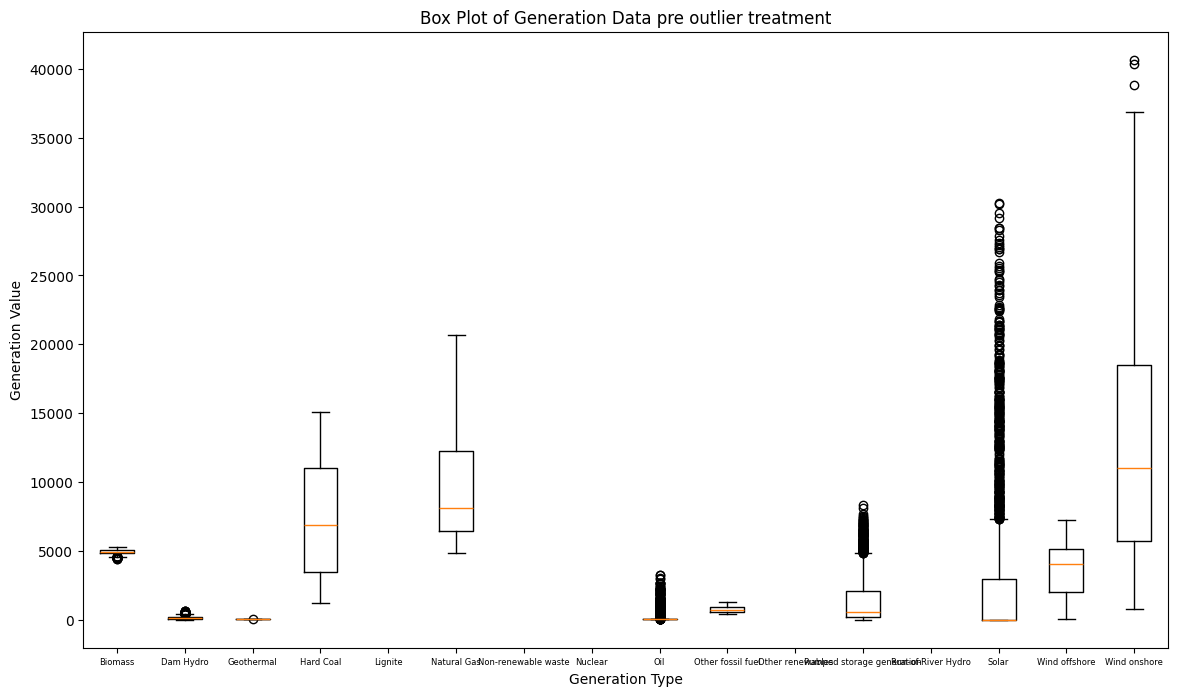

In [13]:
#######plotting to visualize before treating outliers
plt.figure(figsize=(14, 8))
plt.boxplot(value_by_date_region_vs_generation.values, labels=value_by_date_region_vs_generation.columns)
plt.title('Box Plot of Generation Data pre outlier treatment')
plt.xlabel('Generation Type')
plt.ylabel('Generation Value')
plt.xticks(fontsize=6)
plt.show()

In [14]:
####### treating the outliers-replacing with the mode, mean and median are affected by the extreme values
#since its generation, its likely that power output frequents a certain MW since demand is relatively around same value and its also dependent on the install capacity.
# print(pivot_summary)
def replace_outliers_with_mode(data):
# Calculate the mode for each column
    mode_values = data.mode().iloc[0]
    # Iterate over each column
    for column in data.columns:
        # Calculate Tukey fences
        q1 = data[column].quantile(0.25)
        q3 = data[column].quantile(0.75)
        iqr = q3 - q1
        fence_low = q1 - 1.5 * iqr
        fence_high = q3 + 1.5 * iqr
        # Replace outliers with mode value
        outliers = (data[column] < fence_low) | (data[column] > fence_high)
        data.loc[outliers, column] = mode_values[column]
    return data

df_replaced = replace_outliers_with_mode(value_by_date_region_vs_generation)

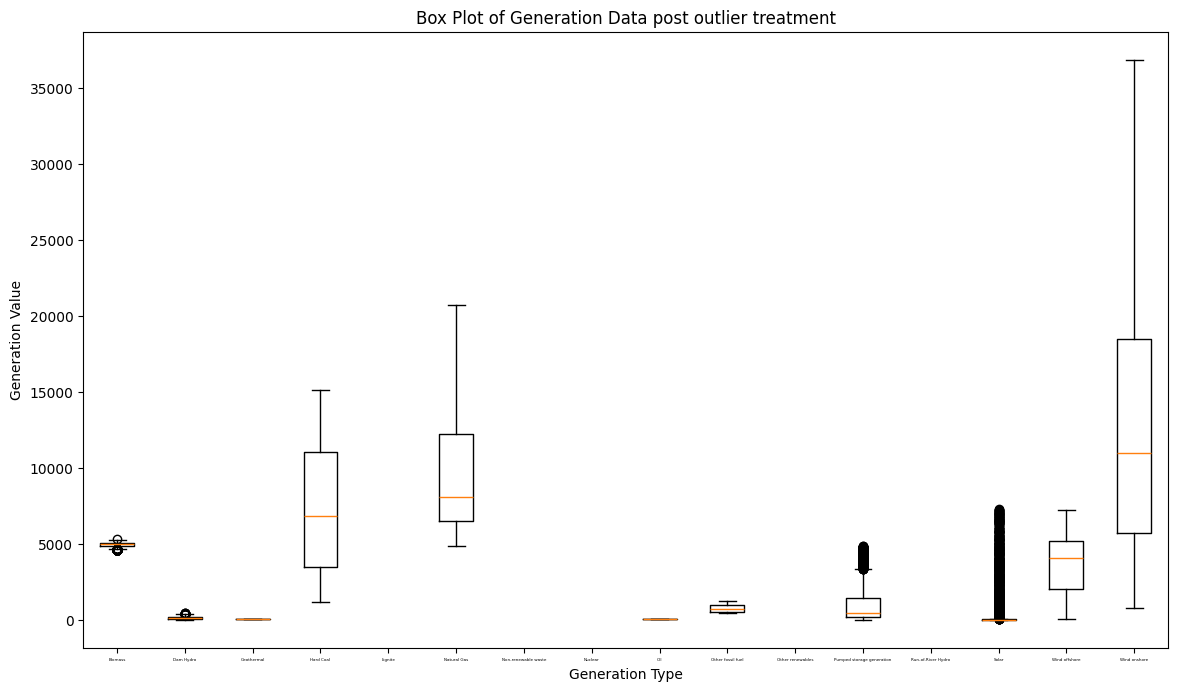

In [15]:
####plot the figure after compare the box plots
plt.figure(figsize=(14, 8))
plt.boxplot(df_replaced.values, tick_labels=df_replaced.columns)
plt.title('Box Plot of Generation Data post outlier treatment')
plt.xlabel('Generation Type')
plt.ylabel('Generation Value')
plt.xticks(fontsize=3)
plt.show()

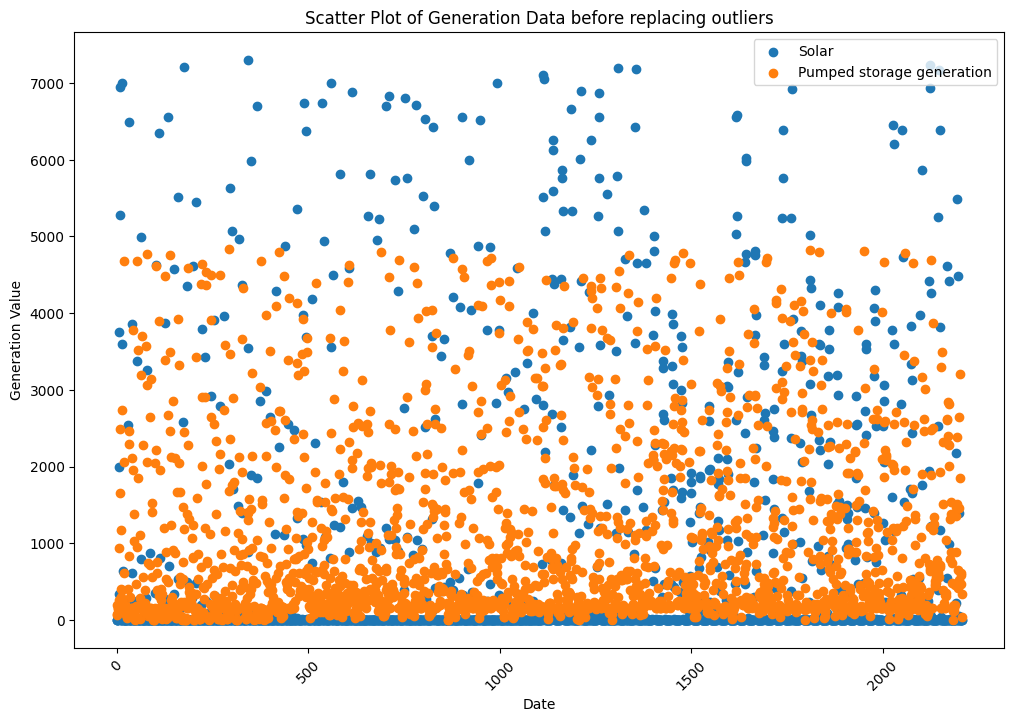

In [16]:
#convert index column into a regular column
df_replaced_reset = df_replaced.reset_index()
value_by_date_region_vs_generation=value_by_date_region_vs_generation.reset_index()

# #visualizing sola and pup storage ,before replacing with mode,  since it has IQR of 0
plt.figure(figsize=(12, 8))  # Increase the figure size (width: 12 inches, height: 8 inches)
plt.scatter(value_by_date_region_vs_generation.index, value_by_date_region_vs_generation['Solar'], label='Solar')
plt.scatter(value_by_date_region_vs_generation.index, value_by_date_region_vs_generation['Pumped storage generation'], label='Pumped storage generation')
plt.title('Scatter Plot of Generation Data before replacing outliers')
plt.xlabel('Date')
plt.ylabel('Generation Value')
plt.legend()
plt.xticks(rotation=45)
plt.show()

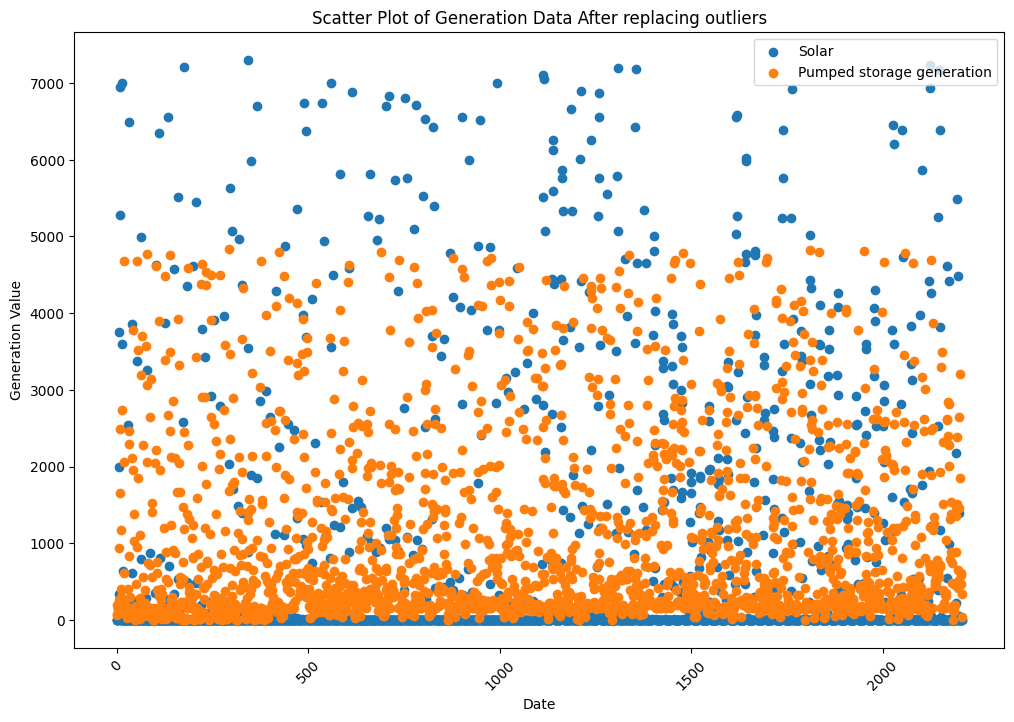

In [17]:
#  #visualizing sola and pup storage ,After replacing with mode
plt.figure(figsize=(12, 8))  # Increase the figure size (width: 12 inches, height: 8 inches)
plt.scatter(df_replaced_reset.index, df_replaced_reset['Solar'], label='Solar')
plt.scatter(df_replaced_reset.index, df_replaced_reset['Pumped storage generation'], label='Pumped storage generation')
plt.title('Scatter Plot of Generation Data After replacing outliers')
plt.xlabel('Date')
plt.ylabel('Generation Value')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [18]:
#the plots looks the same, i think because our mean is pulled to zero traetment wasnt effective?
print(df_replaced.isna().any())
print(df_replaced.head())

generation
Biomass                      False
Dam Hydro                    False
Geothermal                   False
Hard Coal                    False
Lignite                       True
Natural Gas                  False
Non-renewable waste           True
Nuclear                       True
Oil                          False
Other fossil fuel            False
Other renewables              True
Pumped storage generation    False
Run-of-River Hydro            True
Solar                        False
Wind offshore                False
Wind onshore                 False
dtype: bool
generation                   Biomass  Dam Hydro  Geothermal  Hard Coal  \
date_id             region                                               
2022-10-01T00:00:00 Germany  4627.81      74.94       20.81    3206.20   
2022-10-01T01:00:00 Germany  4627.81      90.00       20.81    3212.39   
2022-10-01T02:00:00 Germany  4612.07      74.26       20.81    3025.96   
2022-10-01T03:00:00 Germany  4589.12      70.84

In [19]:
#find the missing data and why its missing 
#visualize missing values
df_nullity = df_replaced.isnull()
print(df_replaced.describe())

generation      Biomass    Dam Hydro  Geothermal     Hard Coal       Lignite  \
count       2208.000000  2208.000000     2208.00   2208.000000   2196.000000   
mean        4937.958904   128.445521       20.81   7357.773483  13368.765173   
std          153.792064    92.466988        0.00   4154.736948   2054.662728   
min         4555.080000    11.640000       20.81   1185.960000   7379.740000   
25%         4877.395000    52.360000       20.81   3458.162500  11865.115000   
50%         4960.500000   103.340000       20.81   6854.065000  13522.655000   
75%         5038.390000   179.737500       20.81  11009.727500  14929.082500   
max         5282.110000   411.660000       20.81  15090.510000  17085.490000   

generation  Natural Gas  Non-renewable waste      Nuclear           Oil  \
count        2208.00000          2199.000000  2185.000000  2.208000e+03   
mean         9633.52188          1178.363738  3843.839227  3.078000e+01   
std          3944.67400            91.204659   196.951

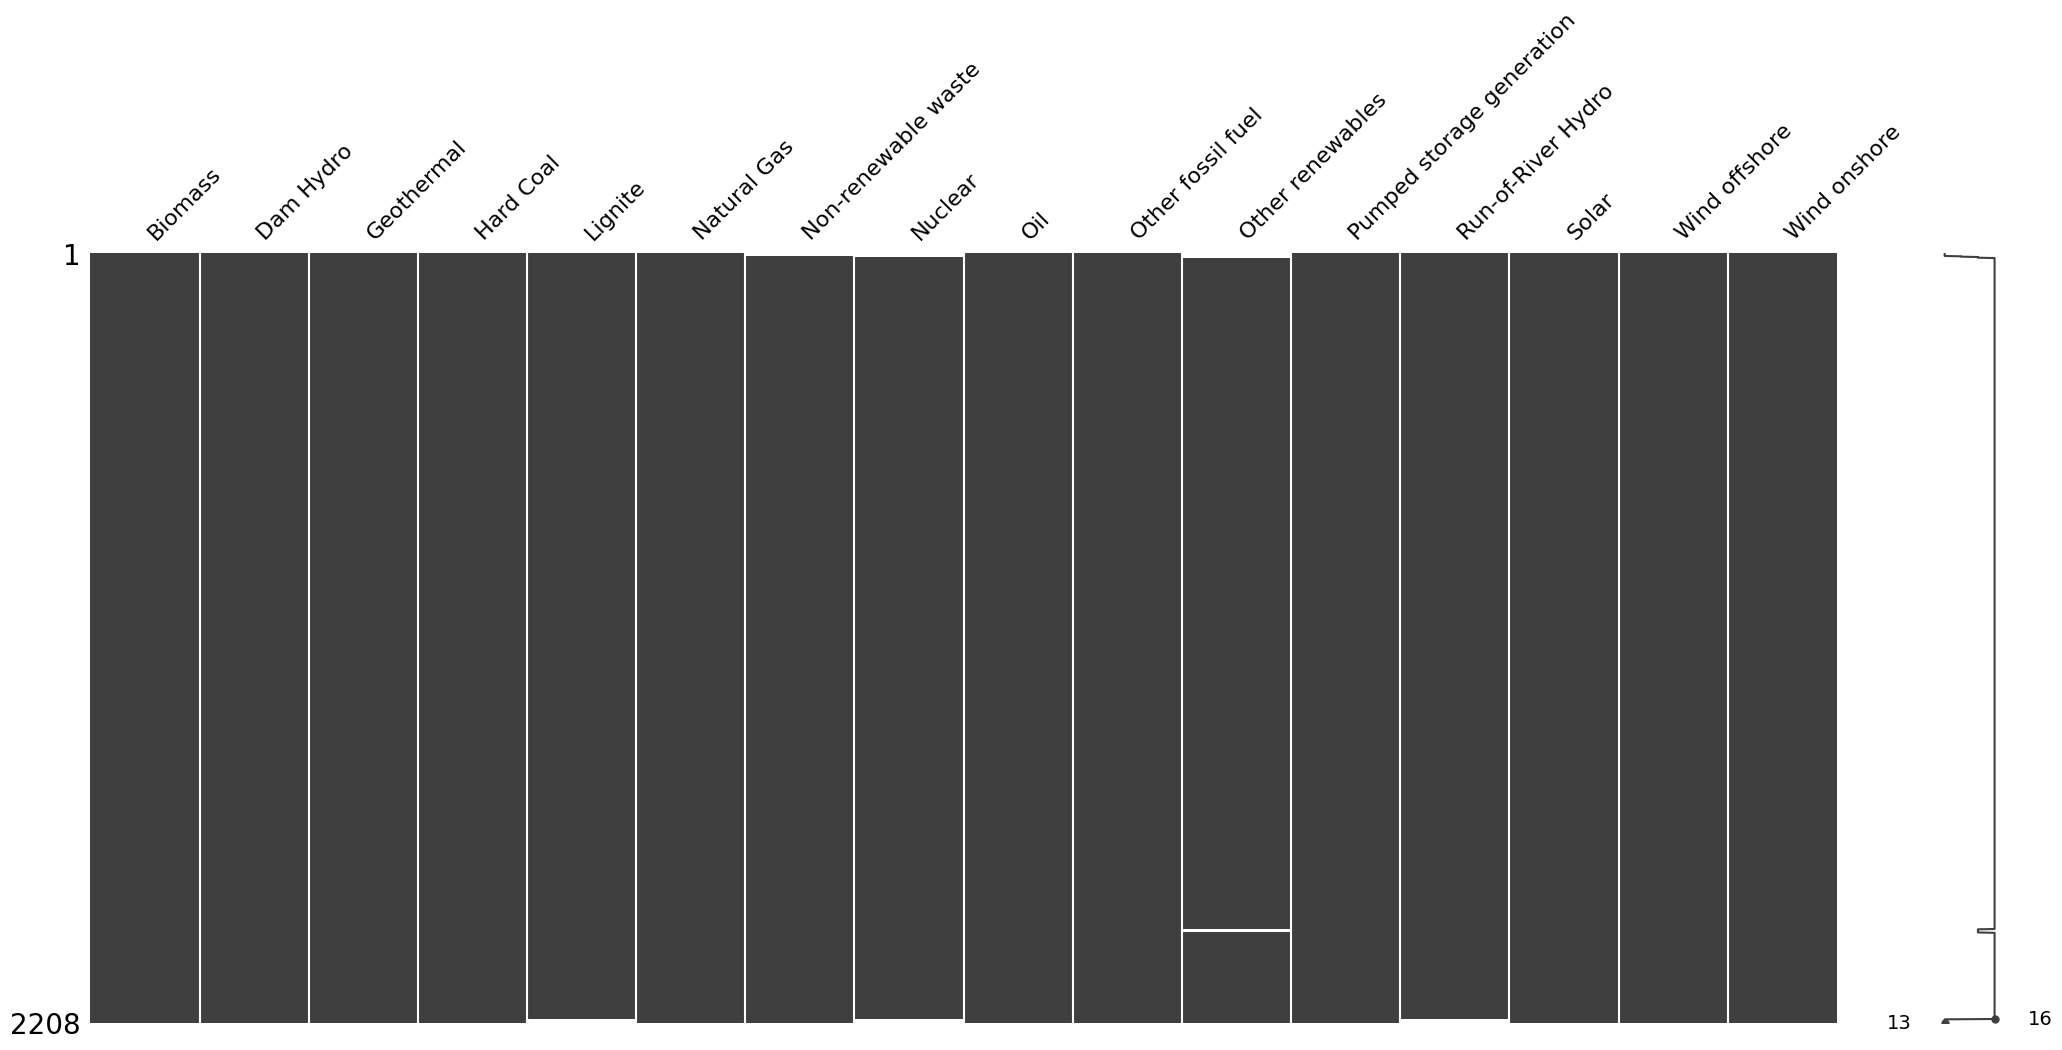

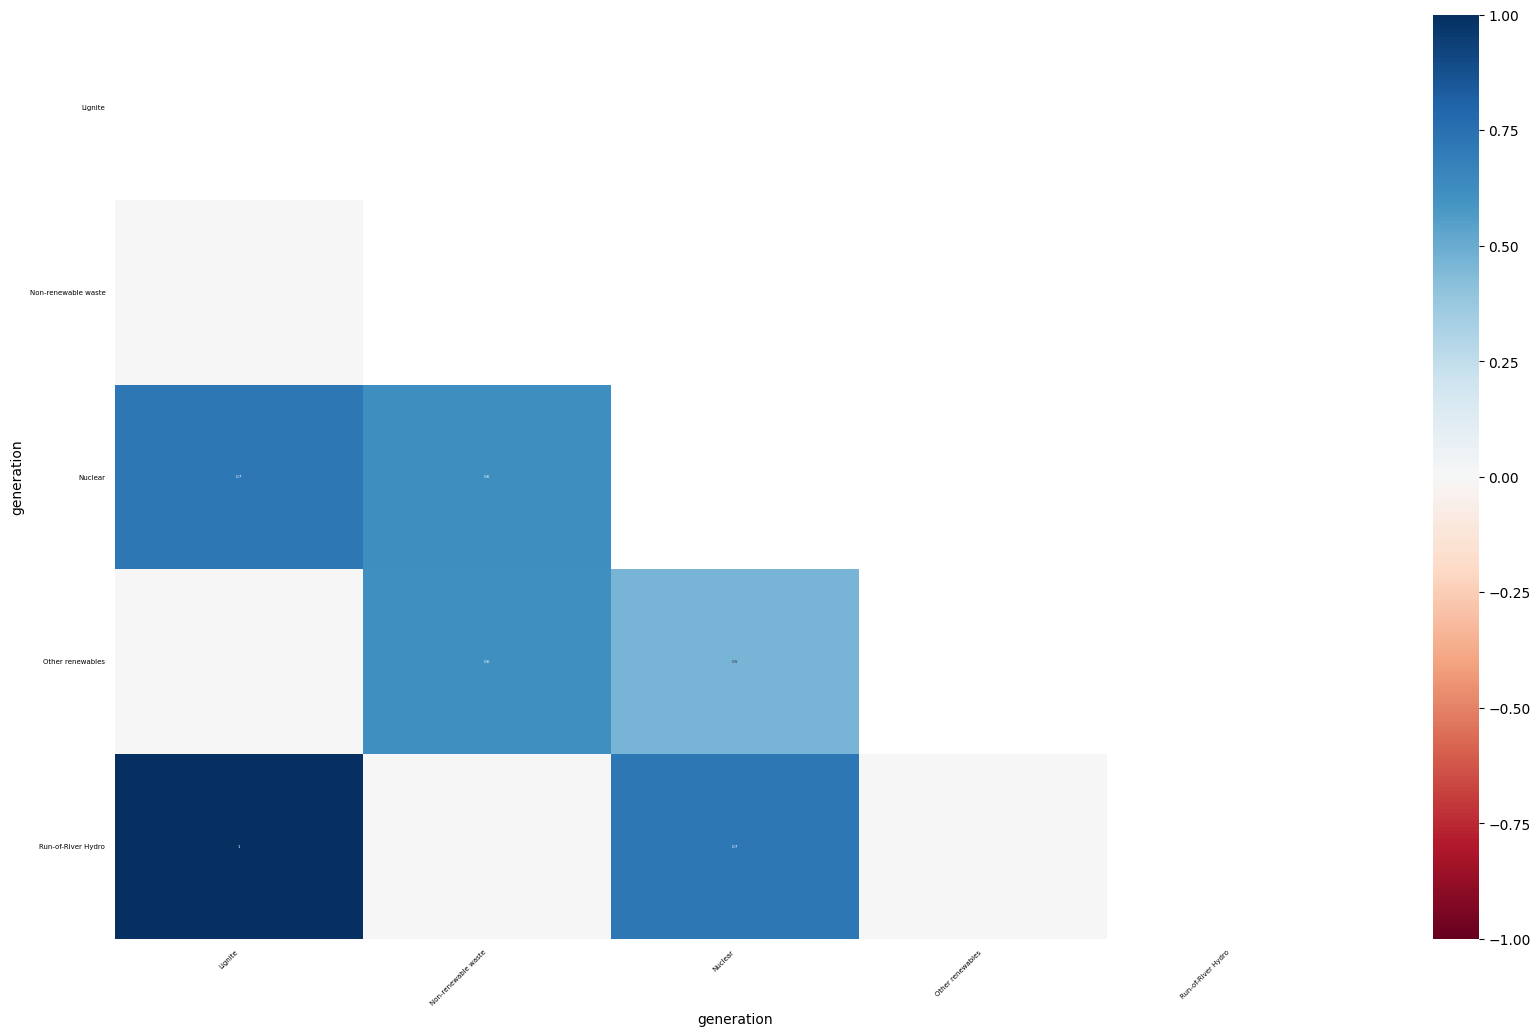

In [20]:
#find patterns in the missing data to seee if there is any correlation among the columns
msno.matrix(df_replaced)
msno.heatmap(df_replaced, fontsize=5)
#there is a corelation 0f 0.9 between nuclear and non-renewable waste mising values
#makes sense that they are dependecies since nuclear is considered non renewable
#corelation between the waste and other renewable, since some renewable produce non-renewable waste like biodiesel?

plt.show()

isna? after imputing missing values
generation
Biomass                      0
Dam Hydro                    0
Geothermal                   0
Hard Coal                    0
Lignite                      0
Natural Gas                  0
Non-renewable waste          0
Nuclear                      0
Oil                          0
Other fossil fuel            0
Other renewables             0
Pumped storage generation    0
Run-of-River Hydro           0
Solar                        0
Wind offshore                0
Wind onshore                 0
dtype: int64


/var/folders/t4/cbfn9d4s6792nzjdvlbqd4vc0000gn/T/ipykernel_12594/1318776524.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df_replaced_mode.values, labels=df_replaced_mode.columns)


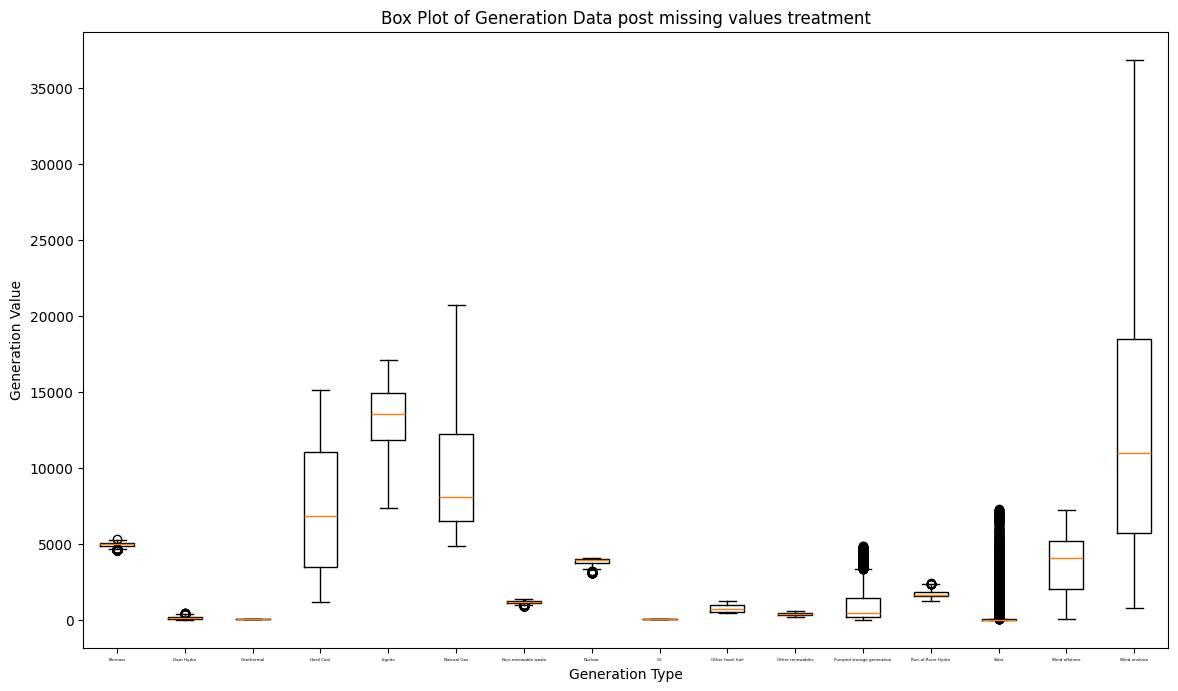

In [21]:
#how to treat the missing values
#used mode because the missing values are MNAR,
#create a copy of the dataset to compare later
df_replaced_mode = df_replaced.copy(deep=True)
mode_imputer = SimpleImputer(strategy='most_frequent')
df_replaced_mode.iloc[:, :] = mode_imputer.fit_transform(df_replaced_mode)

print("isna? after imputing missing values")
print(df_replaced_mode.isna().sum())

#visualize box plot again
plt.figure(figsize=(14, 8))
plt.boxplot(df_replaced_mode.values, labels=df_replaced_mode.columns)
plt.title('Box Plot of Generation Data post missing values treatment')
plt.xlabel('Generation Type')
plt.ylabel('Generation Value')
plt.xticks(fontsize=3)
plt.show()

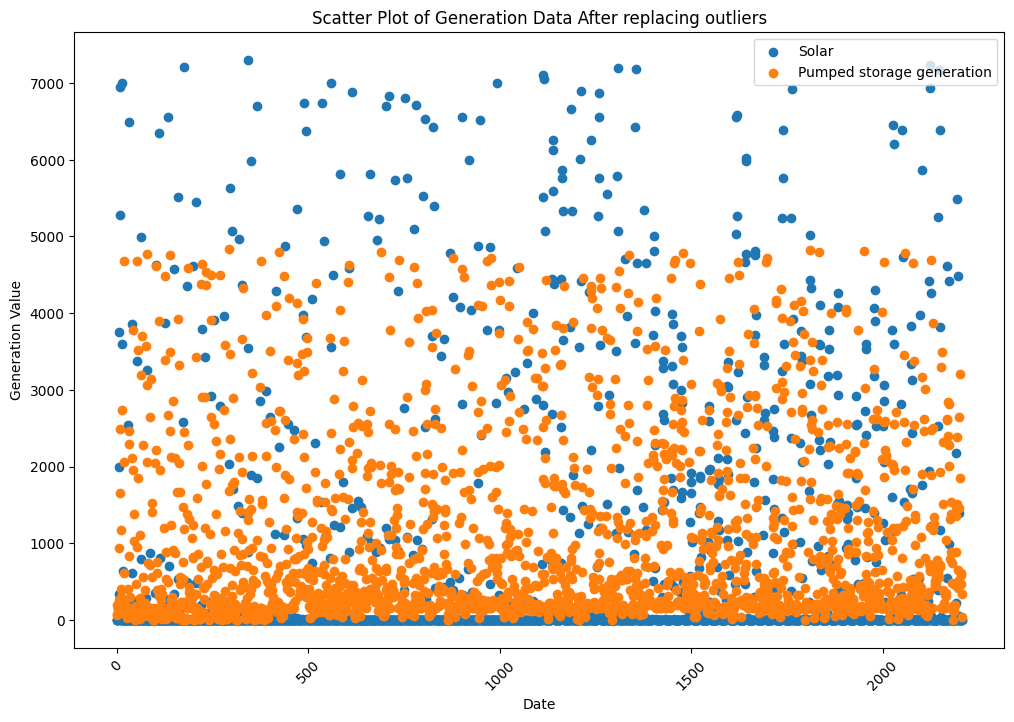

In [22]:
df_replaced_mode_reset = df_replaced_mode.reset_index()
plt.figure(figsize=(12, 8))  # Increase the figure size (width: 12 inches, height: 8 inches)
plt.scatter(df_replaced_mode_reset.index, df_replaced_mode_reset['Solar'], label='Solar')
plt.scatter(df_replaced_mode_reset.index, df_replaced_mode_reset['Pumped storage generation'], label='Pumped storage generation')
plt.title('Scatter Plot of Generation Data After replacing outliers')
plt.xlabel('Date')
plt.ylabel('Generation Value')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [23]:
print(df_replaced_mode.sort_values("Solar").head(20))
print("descending")
print(df_replaced_mode.sort_values("Solar", ascending=False).head(20))
mean = df_replaced['Solar'].mean()
print(df_replaced_mode.describe())
# calculate the aggregated daily and monthly gen
print(df_replaced_mode.head())

generation                   Biomass  Dam Hydro  Geothermal  Hard Coal  \
date_id             region                                               
2022-10-01T00:00:00 Germany  4627.81      74.94       20.81    3206.20   
2022-11-23T18:00:00 Germany  5034.52      94.79       20.81   11406.22   
2022-11-23T17:00:00 Germany  5024.98     164.60       20.81   11389.79   
2022-11-23T16:00:00 Germany  5024.46     165.62       20.81   11539.31   
2022-11-23T13:00:00 Germany  5000.22      28.40       20.81   11362.17   
2022-11-23T12:00:00 Germany  4990.93      22.59       20.81   11323.36   
2022-11-23T11:00:00 Germany  5123.50      47.57       20.81   11220.27   
2022-11-23T10:00:00 Germany  5100.80      44.14       20.81   11087.65   
2022-11-23T09:00:00 Germany  5096.16      47.91       20.81   10929.55   
2022-11-23T05:00:00 Germany  4932.13      55.78       20.81    9775.74   
2022-11-23T04:00:00 Germany  4939.87      25.32       20.81    7810.73   
2022-11-23T03:00:00 Germany  4960.50  

In [24]:
###creating time series
# print(df_replaced_mode.head())
# print(df_replaced_mode.dtypes)
df_replaced_mode.reset_index(inplace=True)
df_replaced_mode['date_id'] = pd.to_datetime(df_replaced_mode['date_id'])
df_replaced_mode.set_index('date_id', inplace=True)
# print("df_replaced_mode")
# print(df_replaced_mode.head())

In [48]:
# Calculate the aggregated daily generation for each type
df_daily = df_replaced_mode.resample('D').asfreq()
print(df_daily.head(1))

             region  Biomass  Dam Hydro  Geothermal  Hard Coal   Lignite  \
date_id                                                                    
2022-10-01  Germany  4627.81      74.94       20.81     3206.2  11722.52   

            Natural Gas  Non-renewable waste  Nuclear    Oil  \
date_id                                                        
2022-10-01      5083.37              1157.48  4001.62  30.78   

            Other fossil fuel  Other renewables  Pumped storage generation  \
date_id                                                                      
2022-10-01             570.09            305.75                       71.0   

            Run-of-River Hydro  Solar  Wind offshore  Wind onshore  
date_id                                                             
2022-10-01             2085.35    0.0        4708.63      23117.49  


In [49]:
# df_monthly = df_daily.resample('M').mean()

agg_dict = {col: 'mean' for col in df_daily.select_dtypes(include='number').columns}
agg_dict['region'] = 'first'

df_monthly = df_daily.resample('M').agg(agg_dict)
print(df_monthly.head(3))

                Biomass   Dam Hydro  Geothermal    Hard Coal       Lignite  \
date_id                                                                      
2022-10-31  4801.141935  104.292258       20.81  3807.943548  12125.528387   
2022-11-30  4993.907667   82.845000       20.81  6392.039333  12975.630333   
2022-12-31  4984.568710   63.042581       20.81  8923.048387  13165.728710   

            Natural Gas  Non-renewable waste      Nuclear    Oil  \
date_id                                                            
2022-10-31  6686.707419          1152.862258  3955.329677  30.78   
2022-11-30  7108.285667          1168.483667  3937.548333  30.78   
2022-12-31  9862.060323          1173.683548  3625.679355  30.78   

            Other fossil fuel  Other renewables  Pumped storage generation  \
date_id                                                                      
2022-10-31         509.323871        311.811290                 141.008065   
2022-11-30         689.632000     

/var/folders/t4/cbfn9d4s6792nzjdvlbqd4vc0000gn/T/ipykernel_12594/2846619764.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_daily.resample('M').agg(agg_dict)


In [35]:
df_daily.reset_index(inplace=True)
print("reset index")
#print(df_daily.head())
df_daily_json = df_daily.to_json(orient='index')
#print(df_daily_json)
print(df_daily.columns)

print("json")
print(df_daily_json)
file_path = './data/df_daily.csv'
# Save the DataFrame to the CSV file option
df_daily_json = df_daily.to_json(orient='columns')
df_daily.to_csv(file_path, index=True)

reset index
Index(['index', 'date_id', 'region', 'Biomass', 'Dam Hydro', 'Geothermal',
       'Hard Coal', 'Lignite', 'Natural Gas', 'Non-renewable waste', 'Nuclear',
       'Oil', 'Other fossil fuel', 'Other renewables',
       'Pumped storage generation', 'Run-of-River Hydro', 'Solar',
       'Wind offshore', 'Wind onshore'],
      dtype='object', name='generation')
json
{"0":{"index":0,"date_id":1664582400000,"region":"Germany","Biomass":4627.81,"Dam Hydro":74.94,"Geothermal":20.81,"Hard Coal":3206.2,"Lignite":11722.52,"Natural Gas":5083.37,"Non-renewable waste":1157.48,"Nuclear":4001.62,"Oil":30.78,"Other fossil fuel":570.09,"Other renewables":305.75,"Pumped storage generation":71.0,"Run-of-River Hydro":2085.35,"Solar":0.0,"Wind offshore":4708.63,"Wind onshore":23117.49},"1":{"index":1,"date_id":1664668800000,"region":"Germany","Biomass":4643.02,"Dam Hydro":143.72,"Geothermal":20.81,"Hard Coal":1851.43,"Lignite":11722.52,"Natural Gas":4942.26,"Non-renewable waste":1265.11,"Nuclear"

In [36]:
renewable_sources = ['Biomass', 'Dam Hydro', 'Geothermal', 'Other renewables',
                 'Pumped storage generation', 'Run-of-River Hydro',
                 'Solar', 'Wind offshore', 'Wind onshore']
non_renewable_sources = ['Hard Coal', 'Lignite', 'Natural Gas', 'Non-renewable waste',
                     'Nuclear', 'Oil', 'Other fossil fuel']
renewable_generation = df_replaced_mode[df_replaced_mode.columns[df_replaced_mode.columns.isin(renewable_sources)]]
# print("renewable")
# print(renewable_generation.head())
non_renewable_generation = df_replaced_mode[df_replaced_mode.columns[df_replaced_mode.columns.isin(non_renewable_sources)]]

In [37]:
#hourly generation renewable
#aggregated daily renewable
#aggregated monthly renewable
# print(renewable_generation.head())
# print(df_replaced_mode.columns)
# Hourly electricity generation
hourly_table = pd.pivot_table(df_replaced_mode, index=df_replaced_mode.index.hour,
                              values=renewable_sources+non_renewable_sources,
                              aggfunc='sum', margins=True)

In [38]:
# Daily electricity generation
daily_table = pd.pivot_table(df_replaced_mode, index=df_replaced_mode.index.date,
                             values=renewable_sources+non_renewable_sources,
                             aggfunc='sum', margins=True, margins_name='Total')

In [39]:
# Monthly electricity generation
monthly_table = pd.pivot_table(df_replaced_mode, index=df_replaced_mode.index.to_period('M'),
                               values=renewable_sources+non_renewable_sources,
                               aggfunc='sum', margins=True, margins_name='Total')

In [41]:
# # # Calculate the percentage of total generation
#calculating the aggregated renewable 
# df_daily_renewable_generation = renewable_generation.resample('D').mean()
# df_daily_renewable_generation_pivot =pd.pivot_table(df_daily_renewable_generation, index=df_daily_renewable_generation.index.hour,
#                               values=renewable_sources,
#                               aggfunc='sum', margins=True)
# print("col  df_daily_renewable_generation_pivot")
# print( df_daily_renewable_generation_pivot.columns)
# print( df_daily_renewable_generation_pivot.head())

In [ ]:
# #aggregated renewable monthly
# df_monthly_renewable_generation =  df_daily_renewable_generation.resample('M').mean()
# #calculating the aggregated non-renewable 
# df_daily_non_renewable_generation = non_renewable_generation.resample('D').mean()
# #aggregated non renewable
# df_monthly_non_renewable_generation =  df_daily_non_renewable_generation.resample('M').mean()
# hourly_table_percent = (hourly_table / hourly_table['Total']) * 100
# daily_table_percent = (daily_table / daily_table['Total']) * 100
# monthly_table_percent = (monthly_table / monthly_table['Total']) * 100
# print(hourly_table_percent)
# print(daily_table_percent)
# print(monthly_table_percent)
# print( monthly_table.head())

In [50]:
import matplotlib.pyplot as plt

# Convert from MWh to GWh
df_daily_gwh = df_daily / 1000  

# Plot stacked area
plt.figure(figsize=(12, 6))
plt.stackplot(
    df_daily_gwh.index, 
    [df_daily_gwh[col] for col in df_daily_gwh.columns],
    labels=df_daily_gwh.columns
)

plt.legend(loc="upper left", ncol=3)
plt.title("Daily Power Generation in Germany by Fuel Type (GWh)")
plt.xlabel("Date")
plt.ylabel("Generation (GWh)")
plt.tight_layout()
plt.show()


TypeError: unsupported operand type(s) for /: 'str' and 'int'